<a href="https://colab.research.google.com/github/sdhar-pycourse/DSS310/blob/main/KaggleSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries & File

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
model_data= pd.read_csv('http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv', low_memory=False)

In [3]:
model_data.describe()


,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [4]:
model_data.isnull().sum().max()

0

In [5]:
model_data.columns


Index(['date', 'device', 'failure', 'metric1', 'metric2', 'metric3', 'metric4',
       'metric5', 'metric6', 'metric7', 'metric8', 'metric9'],
      dtype='object')

# High Level Insights

In [6]:
print('No event', round(model_data['failure'].value_counts()[0]/len(model_data) * 100,2), '% of the dataset')
print('event', round(model_data['failure'].value_counts()[1]/len(model_data) * 100,2), '% of the dataset')

No event 99.91 % of the dataset
event 0.09 % of the dataset


In [7]:
num_cols=model_data.columns[model_data.dtypes=='int64']

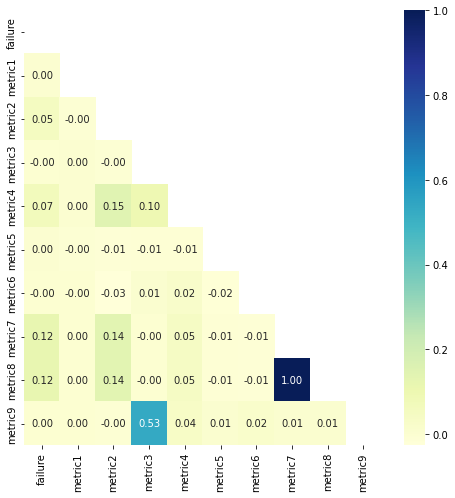

In [8]:
corr = model_data[num_cols].corr()
matrix = np.triu(corr)
# plot heatmap
plt.figure(figsize = (8,8))
sns.heatmap(corr, 
            xticklabels=corr.columns.values, yticklabels=corr.columns.values,
            cmap='YlGnBu', annot=True, fmt=".2f", mask= matrix
           )
plt.show()

# Prediction

## Scaling

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()
minmax_scaler= MinMaxScaler()


In [10]:
metric=['metric1', 'metric2', 'metric3', 'metric4',
       'metric5', 'metric6', 'metric7', 'metric8','metric9']

In [11]:
model_data[metric]= minmax_scaler.fit_transform(model_data[metric])

In [12]:
model_data.date

0          1/1/15
1          1/1/15
2          1/1/15
3          1/1/15
4          1/1/15
           ...   
124489    11/2/15
124490    11/2/15
124491    11/2/15
124492    11/2/15
124493    11/2/15
Name: date, Length: 124494, dtype: object

In [13]:
model_data.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,0.501302,0.002455,0.000399,0.001045,0.136316,0.377514,0.000352,0.000352,0.000666
std,0.029167,0.288602,0.033550,0.007451,0.013751,0.164361,0.143874,0.008939,0.008939,0.010236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.251023,0.000000,0.000000,0.000000,0.072165,0.321328,0.000000,0.000000,0.000000
50%,0.000000,0.502978,0.000000,0.000000,0.000000,0.092784,0.362462,0.000000,0.000000,0.000000
75%,0.000000,0.750837,0.000000,0.000000,0.000000,0.113402,0.450202,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


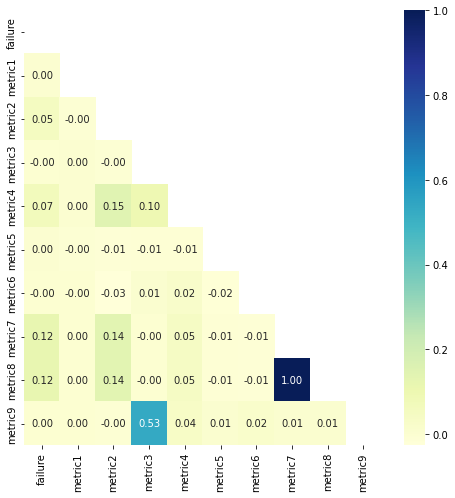

In [14]:
corr = model_data[num_cols].corr()
matrix = np.triu(corr)
# plot heatmap
plt.figure(figsize = (8,8))
sns.heatmap(corr, 
            xticklabels=corr.columns.values, yticklabels=corr.columns.values,
            cmap='YlGnBu', annot=True, fmt=".2f", mask= matrix
           )
plt.show()

In [15]:
model_data['date']= pd.to_datetime(model_data.date)

In [16]:
model_data.sort_values('date', ascending=True, inplace=True)

In [17]:
# The shift of (1) should go in here

In [17]:
model_data.head(20)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,2015-01-01,S1F01085,0,0.883224,0.000862,0.0,0.031212,0.051546,0.591204,0.0,0.0,0.000374
779,2015-01-01,W1F0Y13C,0,0.959770,0.000000,0.0,0.000000,0.030928,0.269554,0.0,0.0,0.000160
778,2015-01-01,W1F0XKWR,0,0.367250,0.000000,0.0,0.000000,0.061856,0.000032,0.0,0.0,0.000000
777,2015-01-01,W1F0X7QX,0,0.663608,0.000000,0.0,0.000000,0.113402,0.315863,0.0,0.0,0.000000
776,2015-01-01,W1F0X7PR,0,0.053815,0.000000,0.0,0.000000,0.082474,0.277638,0.0,0.0,0.000000
775,2015-01-01,W1F0X7P2,0,0.136089,0.000000,0.0,0.000000,0.123711,0.314810,0.0,0.0,0.000000
774,2015-01-01,W1F0X711,0,0.075934,0.000000,0.0,0.000000,0.144330,0.315724,0.0,0.0,0.000000
780,2015-01-01,W1F0Y2PY,0,0.540808,0.000000,0.0,0.000000,0.041237,0.264153,0.0,0.0,0.000000
773,2015-01-01,W1F0X70N,0,0.678231,0.000000,0.0,0.000000,0.123711,0.270303,0.0,0.0,0.000000
771,2015-01-01,W1F0X6V0,0,0.716929,0.000000,0.0,0.000000,0.103093,0.309811,0.0,0.0,0.000000


## 5 way Split

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No event', round(model_data['failure'].value_counts()[0]/len(model_data) * 100,2), '% of the dataset')
print('event', round(model_data['failure'].value_counts()[1]/len(model_data) * 100,2), '% of the dataset')

X = model_data[metric]
y = model_data['failure']

sss = StratifiedKFold(n_splits=5, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", min(train_index), max(train_index),"Test:", min(test_index), max(test_index))
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))


No event 99.91 % of the dataset
event 0.09 % of the dataset
Train: 22795 124493 Test: 0 24901
Train: 0 124493 Test: 22795 55814
Train: 0 124493 Test: 49796 79126
Train: 0 124493 Test: 74687 100963
Train: 0 100963 Test: 99594 124493
----------------------------------------------------------------------------------------------------
Label Distributions: 

[9.99146552e-01 8.53447930e-04]
[9.99156559e-01 8.43441240e-04]


## Subsample- 492

In [19]:
# amount of event classes in 492 rows.
event_df = model_data.loc[model_data['failure'] == 1]
non_event_df = model_data.loc[model_data['failure'] == 0][:492]

normal_distributed_df = pd.concat([event_df, non_event_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
776,2015-01-01,W1F0X7PR,0,0.053815,0.000000,0.0,0.0000,0.082474,0.277638,0.0,0.0,0.0
617,2015-01-01,W1F0LZJX,0,0.029712,0.000000,0.0,0.0000,0.123711,0.645066,0.0,0.0,0.0
942,2015-01-01,W1F1Q5EF,0,0.258044,0.000000,0.0,0.0000,0.030928,0.222076,0.0,0.0,0.0
91064,2015-06-10,W1F0Z3KR,1,0.141444,0.000000,0.0,0.0006,0.072165,0.206092,0.0,0.0,0.0
850,2015-01-01,W1F1A4H9,0,0.077657,0.005787,0.0,0.0000,0.041237,0.000015,0.0,0.0,0.0


Distribution of the Classes in the subsample dataset
0    0.822742
1    0.177258
Name: failure, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


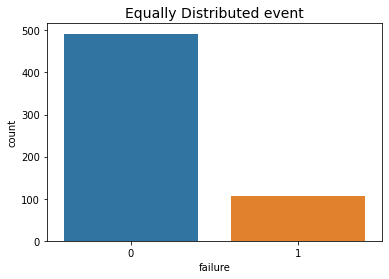

In [20]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['failure'].value_counts()/len(new_df))

sns.countplot('failure', data=new_df)
plt.title('Equally Distributed event', fontsize=14)
plt.show()

## Ramdom Undersample- 2 D representation

In [21]:
# New_df is from the random undersample data (fewer instances)
X = new_df[metric]
y = new_df['failure']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


T-SNE took 4.1 s
PCA took 0.026 s
Truncated SVD took 0.0029 s


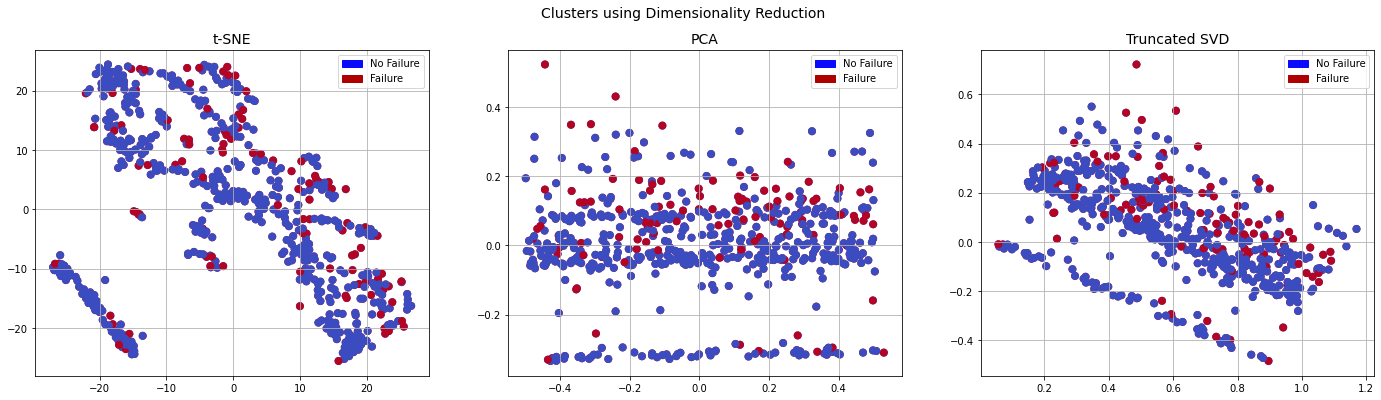

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Failure')
red_patch = mpatches.Patch(color='#AF0000', label='Failure')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Failure', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Failure', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Failure', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Failure', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Failure', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Failure', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()


# Bootstraping Classifcation with Random sample data

In [23]:
# Undersampling before cross validating (prone to overfit)
X = new_df[metric]
y = new_df['failure']

In [25]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [27]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [28]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 83.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 81.0 % accuracy score
Classifiers:  SVC Has a training score of 83.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 85.0 % accuracy score


## Random Forest GridSearchCV

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=3,
                       n_estimators=9)

In [30]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9083333333333333


In [31]:
events = y_test
predictions = clf.predict(X_test)

In [32]:
from sklearn.metrics import classification_report

y_true = events
y_pred = predictions

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        99
           1       0.78      0.67      0.72        21

    accuracy                           0.91       120
   macro avg       0.85      0.81      0.83       120
weighted avg       0.90      0.91      0.91       120



In [33]:
# Class count
count_class_0, count_class_1 = new_df.failure.value_counts()

# Divide by class
df_class_0 = new_df[new_df['failure'] == 0]
df_class_1 = new_df[new_df['failure'] == 1]

Random under-sampling:
0    106
1    106
Name: failure, dtype: int64


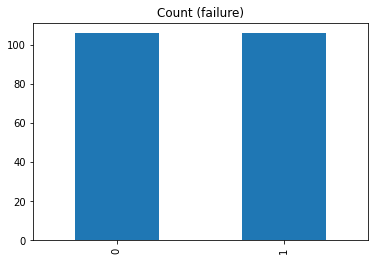

In [34]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.failure.value_counts())

df_test_under.failure.value_counts().plot(kind='bar', title='Count (failure)');

Random over-sampling:
0    492
1    492
Name: failure, dtype: int64


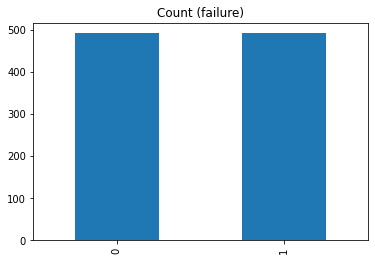

In [35]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.failure.value_counts())

df_test_over.failure.value_counts().plot(kind='bar', title='Count (failure)');

In [36]:
import imblearn

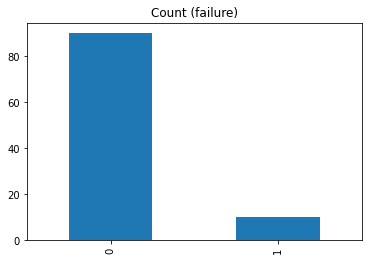

In [37]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (failure)');

## SMOTE Over/ Undersample

In [38]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

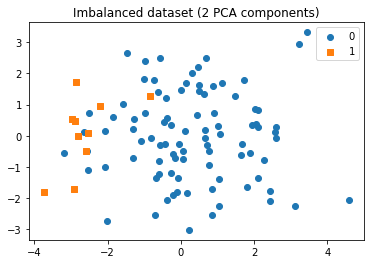

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

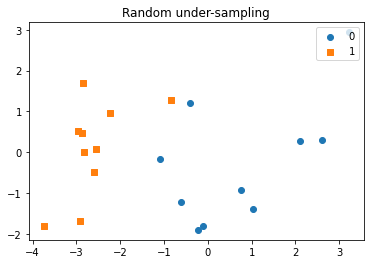

In [40]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus= rus.fit_resample(X, y)


plot_2d_space(X_rus, y_rus, 'Random under-sampling')

80 new random picked points


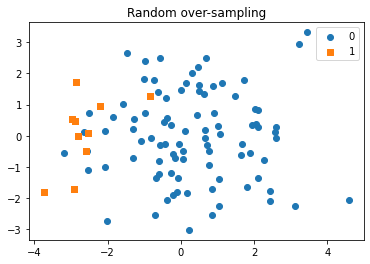

In [41]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

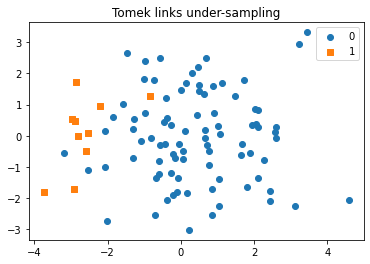

In [42]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl= tl.fit_resample(X, y)

# print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

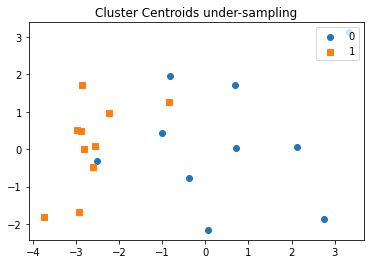

In [43]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

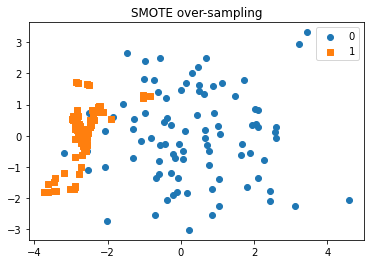

In [44]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

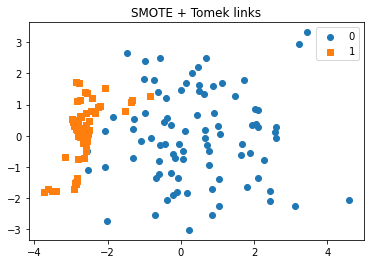

In [45]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_resample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

In [46]:
# Undersampling before cross validating (prone to overfit)
X = X_smt
y = y_smt

## Classifiers on SMOTE data

In [47]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [49]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 94.0 % accuracy score


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=3,
                       n_estimators=6)

In [52]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9428571428571428


In [53]:
clf.score(X,y)

0.9885057471264368

In [54]:
events = y_test
predictions = clf.predict(X_test)

In [55]:
from sklearn.metrics import classification_report

y_true = events
y_pred = predictions

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.94      0.94      0.94        18

    accuracy                           0.94        35
   macro avg       0.94      0.94      0.94        35
weighted avg       0.94      0.94      0.94        35



In [58]:
X_test

array([[-2.54727863e+00,  6.91031689e-02],
       [-2.74759145e+00,  1.14216433e+00],
       [-2.80520999e+00, -1.39044192e-03],
       [-2.71994553e+00,  5.96676969e-01],
       [-2.56852476e+00, -1.73023222e-01],
       [-2.46272434e+00,  7.84727577e-01],
       [ 4.57457210e+00, -2.06815150e+00],
       [-6.80179645e-01, -1.35671263e+00],
       [-2.86495323e+00,  3.54016389e-01],
       [-2.59495962e+00, -4.74281691e-01],
       [-2.56033834e+00, -7.97286899e-02],
       [ 8.88449970e-01,  7.29095352e-01],
       [ 7.18382421e-01, -2.91384288e-01],
       [ 8.46528221e-01, -1.70841869e+00],
       [ 1.10941911e+00,  1.70492526e+00],
       [-8.43994584e-01,  1.27481640e+00],
       [-3.40264942e+00, -1.76016089e+00],
       [ 1.67452196e+00, -2.47465958e-01],
       [-5.68173915e-01, -3.08631697e-01],
       [-2.91679479e+00,  3.46023715e-01],
       [-2.69987776e+00,  3.03963624e-02],
       [-2.90215934e+00,  4.89784581e-01],
       [-2.93998110e+00,  4.27461903e-01],
       [-2.

In [56]:
! pip install scikit-optimize


     |████████████████████████████████| 100 kB 4.6 MB/s 


In [59]:
model_data.sort_values('date', ascending= True, inplace=True)

In [78]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(model_data, model_data['failure'], test_size=0.33, shuffle= False)

In [60]:
train= model_data.loc[model_data.date <= '2015-05-19']
test= model_data.loc[model_data.date > '2015-05-19']
X_train= train[metric].values
y_train= train.failure.values
X_test= test[metric].values
y_test= test.failure.values

## Autocorellation

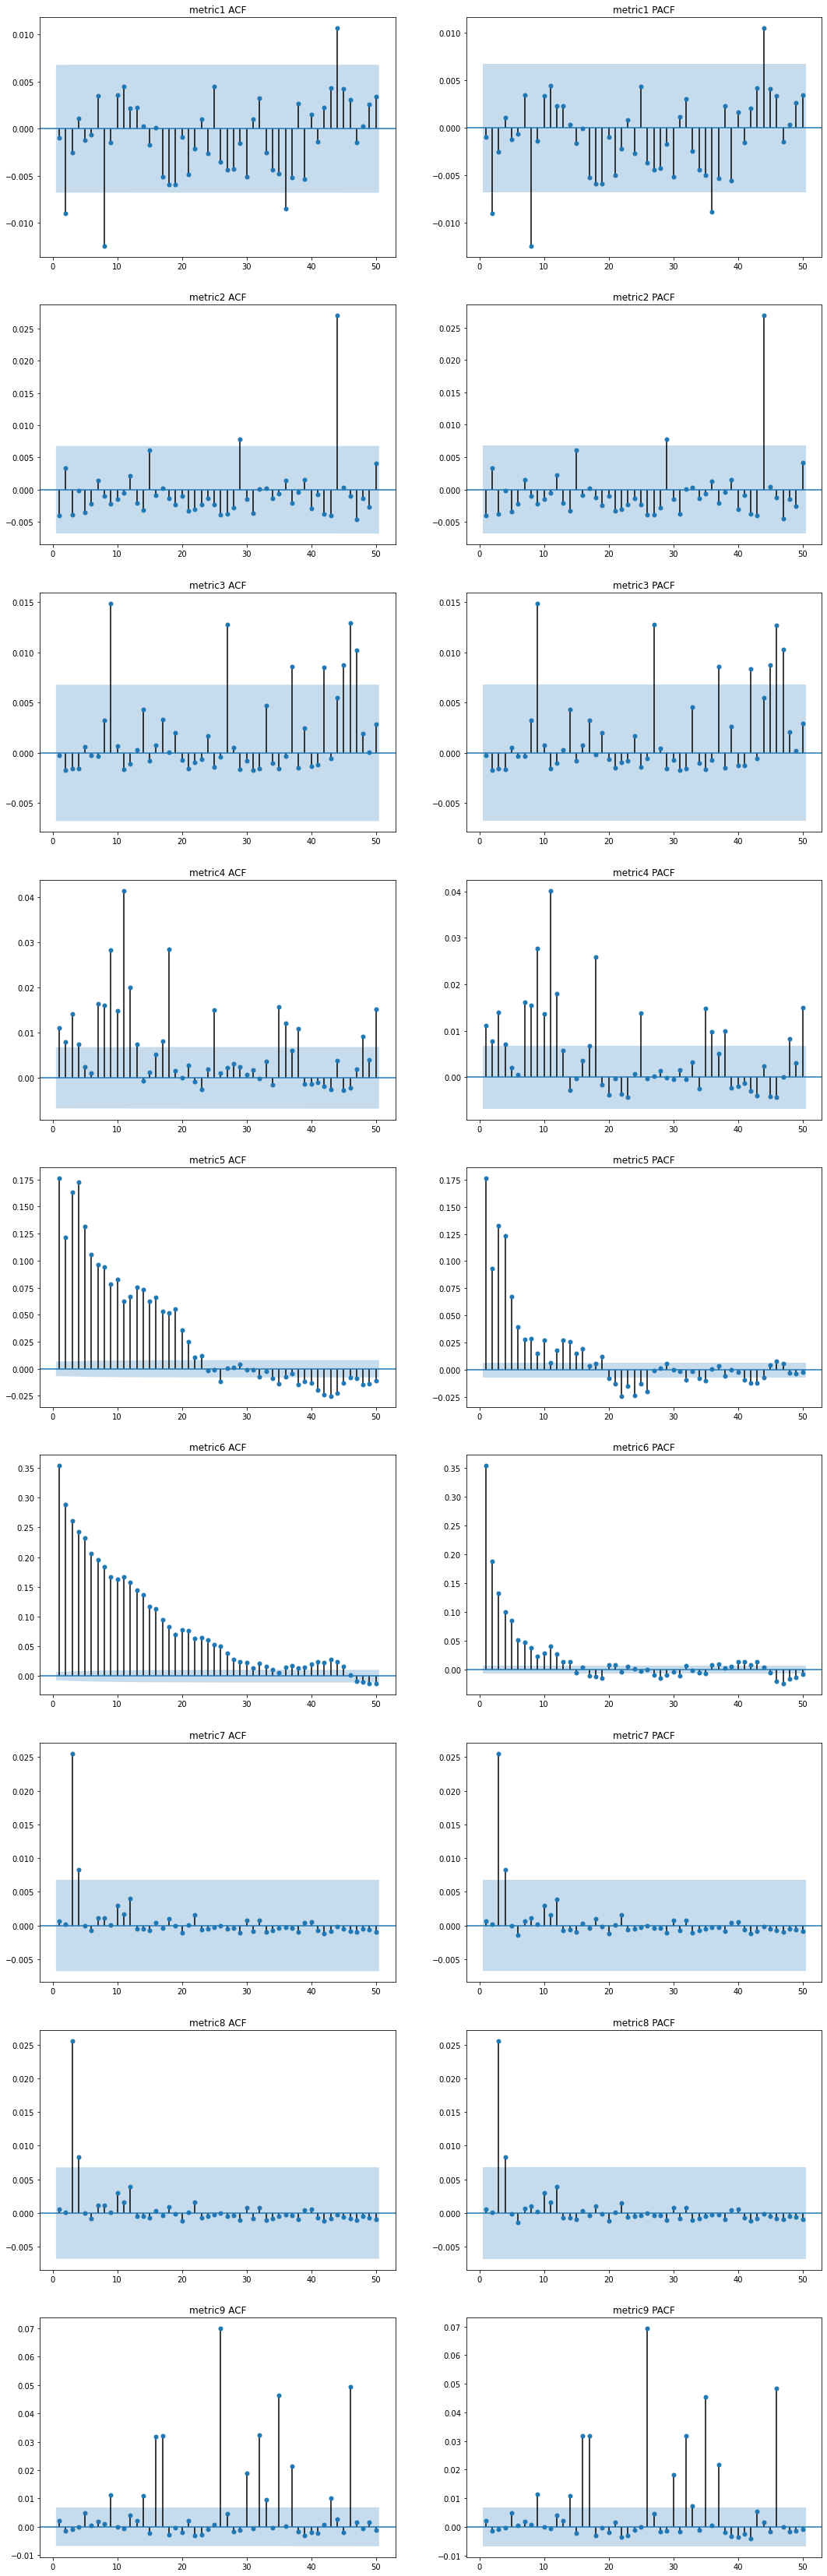

In [87]:
#selected plotting functions
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
f, axes = plt.subplots(9,2,figsize=(18,60));
for i,ax in enumerate(axes):
    plot_acf(train[metric].iloc[:,i], zero=False, ax=ax[0], title=metric[i]+ ' ACF')
    plot_pacf(train[metric].iloc[:,i], zero=False, ax=ax[1],  title=metric[i]+ ' PACF')
plt.show()

## VIF

In [61]:
X_train= train[metric].values
y_train= train.failure.values
X_test= test[metric].values
y_test= test.failure.values

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = metric
vif_data["VIF"] = [variance_inflation_factor(X_train, i)
                          for i in range(X_train.shape[1])]


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [75]:
metric=vif_data.loc[vif_data.VIF < 10, 'feature'].tolist()
metric.append('metric7')

In [77]:
X_train= train[metric].values
y_train= train.failure.values
X_test= test[metric].values
y_test= test.failure.values

## SMOTENN

Before: 71 83484 After: 83409 166818


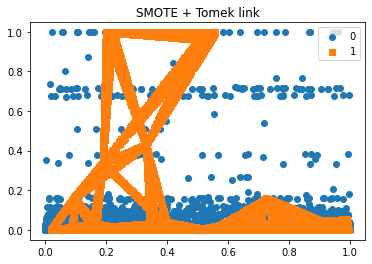

In [80]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto', random_state=4242)
X_smt, y_smt = smt.fit_resample(X_train, y_train)
print('Before:', sum(y_train), len(y_train), 'After:', sum(y_smt), len(y_smt))
plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek link')

In [129]:
sum(y_smt)

84

# XGBClassifier

In [81]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.5 MB/s 


In [83]:
#creating deepcopy of model instances
from copy import deepcopy

#array manipulations
import numpy as np

#dataframe and its manipulations
import pandas as pd

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#selected plotting functions
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

#XGBoost library
import xgboost as xgb

#Python standard libraries
import time
import warnings

#setting default resolution of figures
mpl.rcParams['figure.dpi'] = 200

In [84]:
%%time

#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X_train , y_train)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=5)
clf0.fit(X_train, y_train)

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X_train)
test_predictions = clf0.predict(X_test)
# unseen_predictions = clf0.predict(df_test.iloc[:,1:])

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
# accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)

#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
# f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
# f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)

#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:,1])
# unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf0.predict_proba(df_test.iloc[:,1:])[:,1])

#best parameters
bp = clf0.best_params_

results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                         'test roc auc score': test_ras,
                         'best_params': bp}

#storing computed values in results dictionary
# results_dict['xgbc0'] = {'iterable_parameter': np.nan,
#                          'classifier': deepcopy(clf0),
#                          'cv_results': df.copy(),
#                          'cfm_train': cfm_train,
#                          'cfm_test': cfm_test,
#                          'cfm_unseen': cfm_unseen,
#                          'train_accuracy': accs_train,
#                          'test_accuracy': accs_test,
#                          'unseen_accuracy': accs_unseen,
#                          'train F1-score label 1': f1s_train_p1,
#                          'train F1-score label 0': f1s_train_p0,
#                          'test F1-score label 1': f1s_test_p1,
#                          'test F1-score label 0': f1s_test_p0,
#                          'unseen F1-score label 1': f1s_unseen_p1,
#                          'unseen F1-score label 0': f1s_unseen_p0,
#                          'test roc auc score': test_ras,
#                          'unseen roc auc score': unseen_ras,
#                          'best_params': bp}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 7.68 s, sys: 68.9 ms, total: 7.74 s
Wall time: 7.88 s


In [85]:
#creating deepcopy of default parameters before manipulations
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [100]:
#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    
    #variable for measuring iteration time
    loop_start = time.time()
       
    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value
    
    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)
    
    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring=make_scorer(f1_score), return_train_score=True, verbose=1, cv=3)
    clf.fit(X_train, y_train)
    
    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    
    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    # unseen_predictions = clf.predict(df_test.iloc[:,1:])
    
    #confusion matrices
    cfm_train = confusion_matrix(y_train, train_predictions)
    cfm_test = confusion_matrix(y_test, test_predictions)
    # cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)
    
    #accuracy scores
    accs_train = accuracy_score(y_train, train_predictions)
    accs_test = accuracy_score(y_test, test_predictions)
    # accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)
    
    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
    # f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
    # f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)
    
    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    # unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf.predict_proba(df_test.iloc[:,1:])[:,1])
    
    #best parameters
    bp = clf.best_params_
    
    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                  'train F1-score label 1': f1s_train_p1,
                                  'train F1-score label 0': f1s_train_p0,
                                  'test F1-score label 1': f1s_test_p1,
                                  'test F1-score label 0': f1s_test_p0,
                                  'test roc auc score': test_ras,
                                  'best_params': bp}
    
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0

Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #1 finished in: 31.998791456222534 seconds
Fitting 3 folds for each of 12 candidates, totalling 36 fits
iteration #2 finished in: 29.322205781936646 seconds
Fitting 3 folds for each of 10 candidates, totalling 30 fits
iteration #3 finished in: 32.788164377212524 seconds
Fitting 3 folds for each of 7 candidates, totalling 21 fits
iteration #4 finished in: 21.988089561462402 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #5 finished in: 19.527286529541016 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #6 finished in: 19.040627002716064 seconds


KeyError: ignored

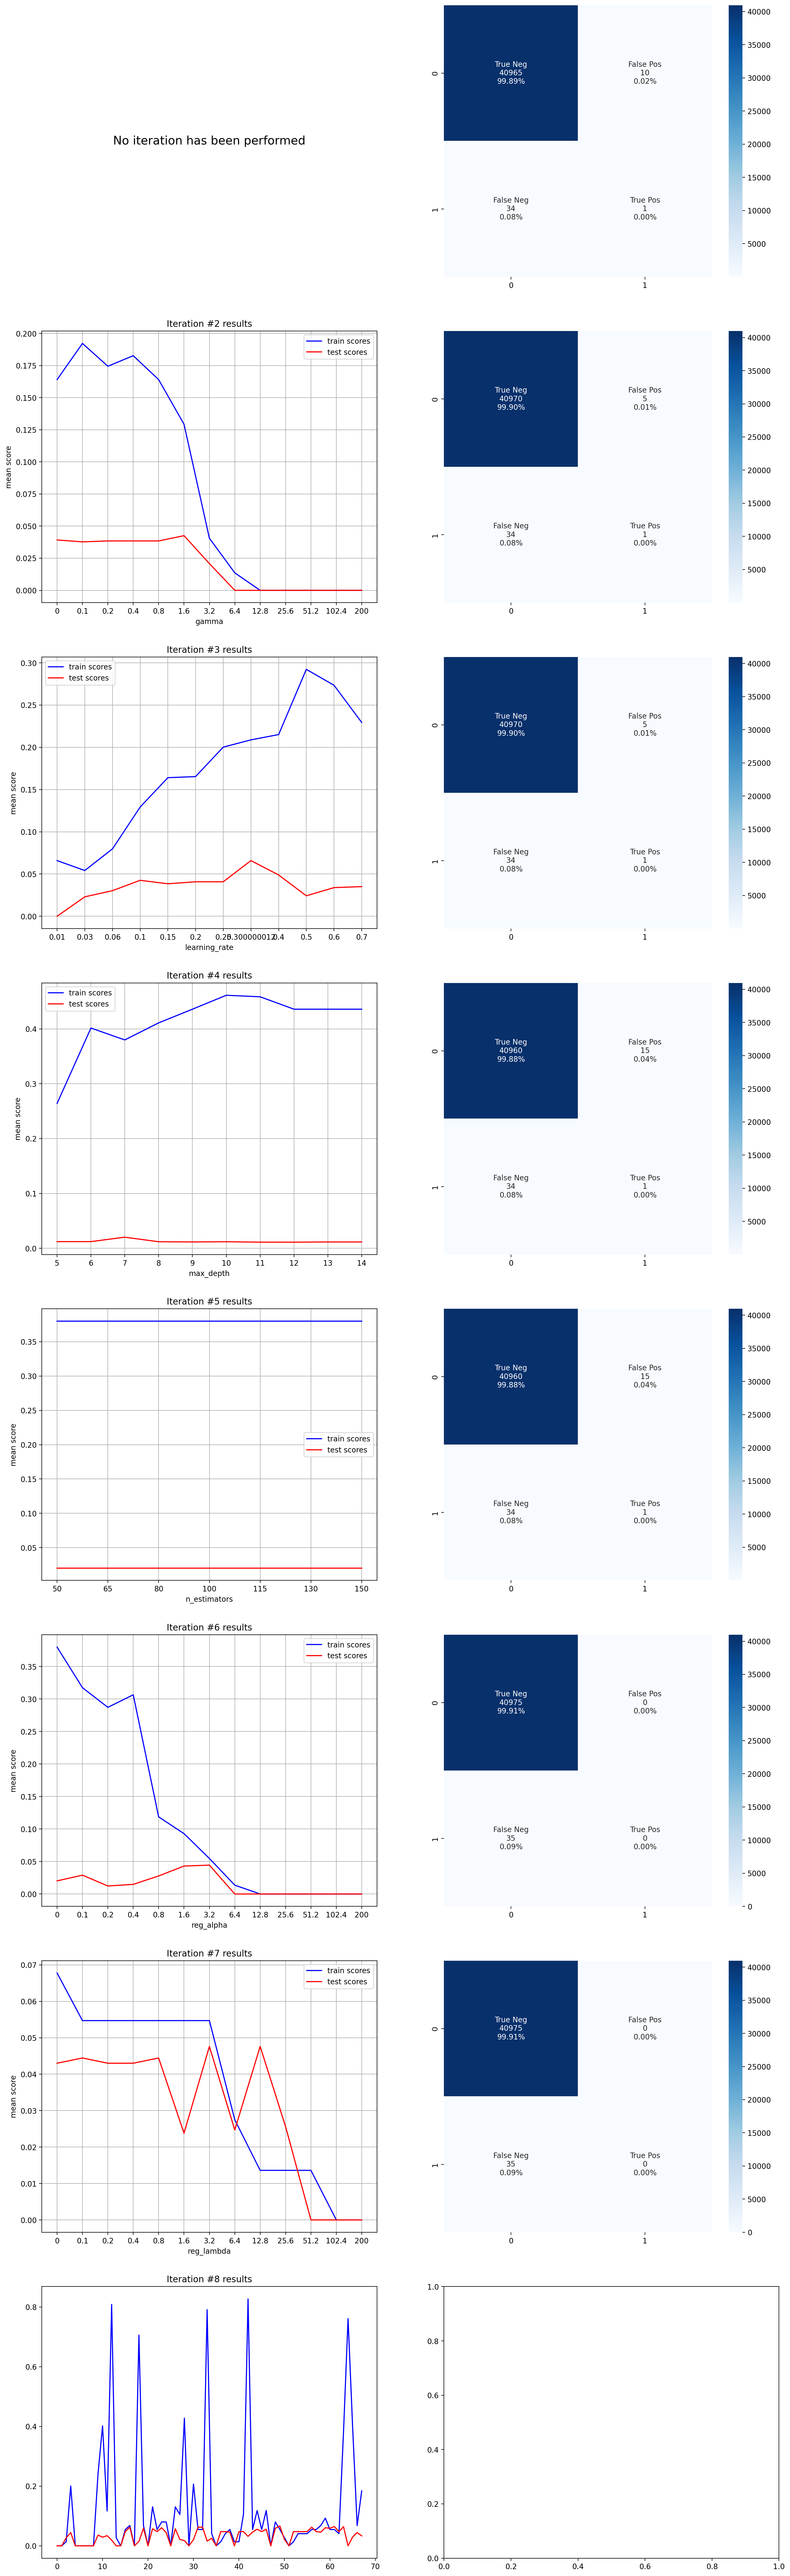

In [101]:
#number of rows depend on number of iterations
nrows = len(results_dict.keys())

#standard group names for confusion matrices
group_names = ['True Neg','False Pos','False Neg','True Pos']

#creating figure
f, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

#iteratively plotting train/test accuracy scores and test confusion matrix
for i,ax in enumerate(axes):
    
    #current key of results dictionary
    ckey = list(results_dict.keys())[i] 
    
    #plotting scores for models other than the benchark model
    if ckey != 'xgbc0':
        x1 = results_dict[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = results_dict[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i+1} results');
               
        ax[0].set_xticks(list(range(0,len([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(results_dict[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
    
    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed', fontsize=16, va='center', ha='center')
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()/np.sum(results_dict[ckey]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
    
plt.show();

In [102]:
%%time

#start time
t0 = time.time()

#No. of jobs
rcvj = gcvj

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

#Executing Randomized Search
clf = RandomizedSearchCV(estimator=xgbc, param_distributions=param_grid, scoring='accuracy', return_train_score=True, verbose=1, cv=3, n_iter=rcvj)
clf.fit(X_train, y_train)
    
#results dataframe
df = pd.DataFrame(clf.cv_results_)
    
#predictions - inputs to confusion matrix
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

    
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)

    
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)

    
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)

    
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
# unseen_ras = roc_auc_score(X_test, clf.predict_proba(X_test))
    
#best parameters
bp = clf.best_params_
    
#storing computed values in results dictionary
results_dict['xgbc_rcv'] = {'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            'test roc auc score': test_ras,
                            'best_params': bp}

#stop time
t1 = time.time()

#elapsed time
rcvt = t1 - t0

Fitting 3 folds for each of 68 candidates, totalling 204 fits
CPU times: user 2min 42s, sys: 935 ms, total: 2min 43s
Wall time: 2min 43s


In [103]:
%%time

#start time
t0 = time.time()

#No. of jobs
bcvj = int(gcvj)

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)

clf = BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=bcvj, scoring='f1', cv=3, return_train_score=True, verbose=3)
clf.fit(X_train, y_train)

#results dataframe
df = pd.DataFrame(clf.cv_results_)
    
#predictions - inputs to confusion matrix
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
# unseen_predictions = clf.predict(df_test.iloc[:,1:])
    
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)
    
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
# accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)
    
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
# f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
# f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)
    
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
# unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf.predict_proba(df_test.iloc[:,1:])[:,1])
    
#best parameters
bp = clf.best_params_
    
#storing computed values in results dictionary
results_dict['xgbc_bcv'] = {'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_test': cfm_test,
                            'train_accuracy': accs_train,
                            'test_accuracy': accs_test,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'test F1-score label 1': f1s_test_p1,
                            'test F1-score label 0': f1s_test_p0,
                            'test roc auc score': test_ras,
                            'best_params': bp}

#stop time
t1 = time.time()

#elapsed time
bcvt = t1 - t0

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END gamma=25.6, learning_rate=0.4, max_depth=14, n_estimators=115, reg_alpha=102.4, reg_lambda=51.2;, score=(train=0.000, test=0.000) total time=   0.8s
[CV 2/3] END gamma=25.6, learning_rate=0.4, max_depth=14, n_estimators=115, reg_alpha=102.4, reg_lambda=51.2;, score=(train=0.000, test=0.000) total time=   0.7s
[CV 3/3] END gamma=25.6, learning_rate=0.4, max_depth=14, n_estimators=115, reg_alpha=102.4, reg_lambda=51.2;, score=(train=0.000, test=0.000) total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END gamma=0.8, learning_rate=0.300000012, max_depth=11, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2;, score=(train=0.080, test=0.133) total time=   0.6s
[CV 2/3] END gamma=0.8, learning_rate=0.300000012, max_depth=11, n_estimators=65, reg_alpha=3.2, reg_lambda=0.2;, score=(train=0.082, test=0.000) total time=   0.6s
[CV 3/3] END gamma=0.8, learning_rate=0.300000012, max_depth=11, n

In [104]:
results_dict.keys()

dict_keys(['xgbc0', 'xgbc1', 'xgbc2', 'xgbc3', 'xgbc4', 'xgbc5', 'xgbc6', 'xgbc_bcv', 'xgbc_rcv'])

In [105]:
#printing benchmark, iterative grid search and randomized search ROC AUC / accuracy scores (test data set)
print(f"Benchmark AUC/accuracy score: {np.round(results_dict['xgbc0']['test roc auc score'],4)} / {np.round(results_dict['xgbc0']['test_accuracy'],4)}")
print(f"Coordinate descent AUC/accuracy score: {np.round(results_dict['xgbc3']['test roc auc score'],4)} / {np.round(results_dict['xgbc3']['test_accuracy'],4)} @ {np.round(gcvt/60,2)} minutes and {gcvj} jobs")
print(f"Randomized search AUC/accuracy score: {np.round(results_dict['xgbc_rcv']['test roc auc score'],4)} / {np.round(results_dict['xgbc_rcv']['test_accuracy'],4)} @ {np.round(rcvt/60,2)} minutes and {rcvj} jobs")
print(f"Bayes search AUC/accuracy score: {np.round(results_dict['xgbc_bcv']['test roc auc score'],4)} / {np.round(results_dict['xgbc_bcv']['test_accuracy'],4)} @ {np.round(bcvt/60,2)} minutes and {bcvj} jobs")
print(f"test F1-score label 1: {np.round(results_dict['xgbc_bcv']['test F1-score label 1'],4)} / {np.round(results_dict['xgbc_bcv']['test F1-score label 1'],4)} @ {np.round(bcvt/60,2)} minutes and {bcvj} jobs")
print(f"test F1-score label 0: {np.round(results_dict['xgbc_bcv']['test F1-score label 0'],4)} / {np.round(results_dict['xgbc_bcv']['test F1-score label 0'],4)} @ {np.round(bcvt/60,2)} minutes and {bcvj} jobs")
print("")

#computing expected time of executing exhaustive grid search
jobs = np.cumprod([len(x) for x in param_grid])[-1]
et = jobs * gcvt / gcvj
print(f"Expected time of executing exhaustive grid search with 3-fold cross-validation: {int(et/60)} minutes and {jobs} jobs")

Benchmark AUC/accuracy score: 0.8743 / 0.9989
Coordinate descent AUC/accuracy score: 0.8385 / 0.9988 @ 2.58 minutes and 68 jobs
Randomized search AUC/accuracy score: 0.5 / 0.9991 @ 2.72 minutes and 68 jobs
Bayes search AUC/accuracy score: 0.777 / 0.999 @ 6.19 minutes and 68 jobs
test F1-score label 1: 0.0 / 0.0 @ 6.19 minutes and 68 jobs
test F1-score label 0: 0.9995 / 0.9995 @ 6.19 minutes and 68 jobs

Expected time of executing exhaustive grid search with 3-fold cross-validation: 23950 minutes and 631800 jobs


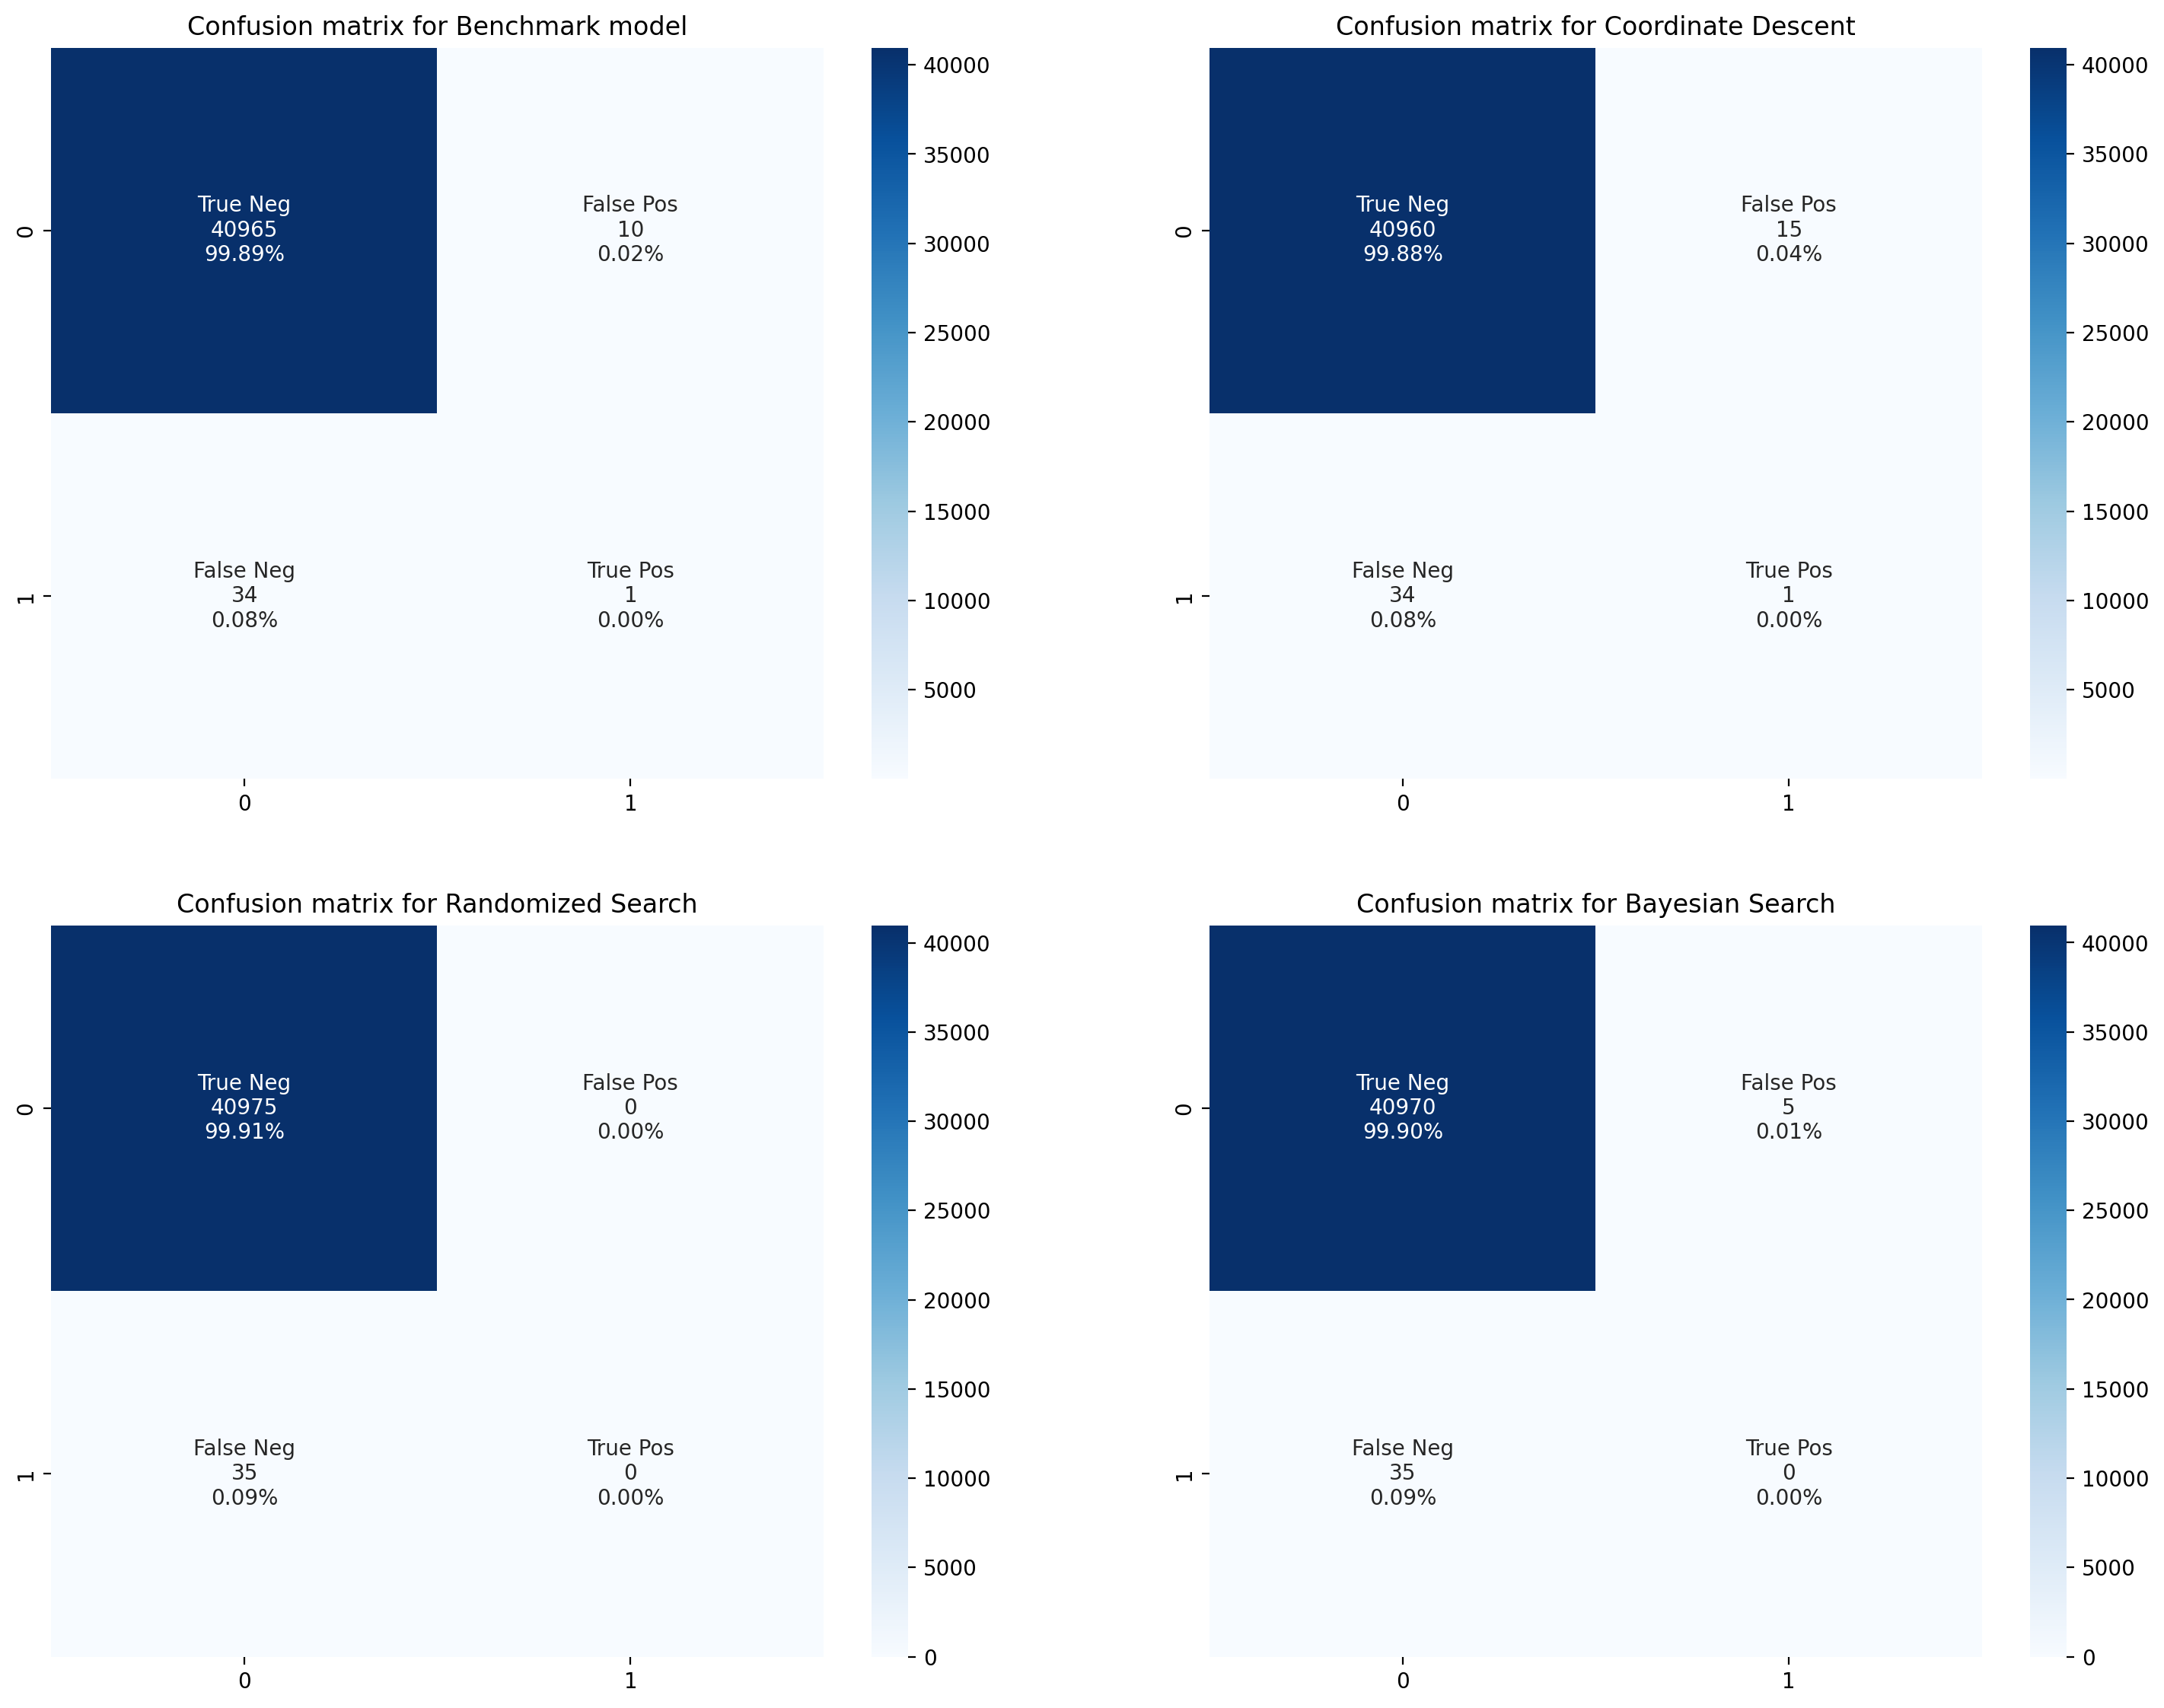

In [106]:
keys = ['xgbc0', 'xgbc3', 'xgbc_rcv', 'xgbc_bcv']
titles = ['Benchmark model', 'Coordinate Descent', 'Randomized Search', 'Bayesian Search']

f, axes = plt.subplots(2,2,figsize=(18,14));

for i,ax in enumerate(axes.flatten()):
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[keys[i]]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[keys[i]]['cfm_test'].flatten()/np.sum(results_dict[keys[i]]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[keys[i]]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax)
    ax.set_title(f"Confusion matrix for {titles[i]}")

In [ ]:
# from sklearn.datasets import load_iris
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0, solver='lbfgs',
#                        multi_class='multinomial').fit(X, y)
# clf.score(X, y)

0.936046511627907